In [194]:
from pathlib import Path

import json
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import seaborn as sns

from seaborn import objects as so


# Data load

In [195]:
exp_plausible_ratio = {}
exp_correct_ratio = {}

base_dir = Path(str(os.getenv("EXPS_DIR")))

exp_names = base_dir.glob("*")
exp_names = [i.name for i in exp_names if ".DS_Store" not in str(i)]

for exp_name in exp_names:
    exp_dir = base_dir / exp_name
    eval_dir = exp_dir / "evals"
    art_eval_dir = exp_dir / "evals_art"

    if not art_eval_dir.exists():
        continue

    exp_name = re.sub("_v\d", "", exp_name)

    all_eval_path = list(eval_dir.glob('*'))
    all_eval_path = sorted(all_eval_path, key = lambda p: int(p.name.split('.')[0]))

    all_art_eval_dir = list(art_eval_dir.glob('*'))
    all_art_eval_dir = sorted(all_art_eval_dir, key = lambda p: int(p.name.split('.')[0]))

    exp_col = {}

    for eval_path in all_eval_path:
        with open(eval_path, 'r') as f:
            a = json.load(f)

        prog_name = a["sample"]["prog_name"]
        testcase_num = a["sample"]["testcase_num"]
        patchs_eval = a["patchs_eval"]

        pass_ratio = sum([i["pass_num"] for i in patchs_eval]) / (testcase_num * 3)

        exp_col[prog_name] = pass_ratio

    exp_plausible_ratio[exp_name] = exp_col

    exp_col = {}
    for art_eval_path in all_art_eval_dir:
        with open(art_eval_path, 'r') as f:
            a = json.load(f)

        prog_name = a["sample"]["prog_name"]

        correct_ratio = [v["is_correct"] == "T" for v in a['patchs_art_evals'].values()]
        correct_ratio = sum(correct_ratio) / 3 

        exp_col[prog_name] = correct_ratio

    exp_correct_ratio[exp_name] = exp_col

exp_correct_ratio.keys()


dict_keys(['gemini-python-with_location', 'gpt35-python-with_lib', 'gpt35-python-with_location', 'gpt4-python-with_location', 'gemini-python-with_lib', 'gpt4-python-with_lib', 'gpt35-python-basic', 'gpt4-python-basic', 'gemini-python-basic'])

In [196]:
from quixbugs import QuixBugsDataset
from collections import Counter

prog_info = QuixBugsDataset("python").prog_info

a = Counter()
bug_type_dict = {}
bug_consequence_dict = {}
bug_impact_dict = {}
for prog in prog_info:
    prog_name = prog["prog_name"]

    bug_type = prog["bug_type"]
    if bug_type == "operator fault":
        bug_type = "variable assign fault"
    if bug_type == "record missing fault":
        bug_type = "variable misuse fault"
    if bug_type == "condition missing fault":
        bug_type = "condition fault"
    if bug_type == "function misuse fault":
        bug_type = "variable misuse fault"
    
        
    bug_type_dict[prog_name] = bug_type
    bug_consequence_dict[prog_name] = prog["bug_consequence"]
    bug_impact_dict[prog_name] = prog["bug_impact"]

    a[bug_type] += 1

a


Counter({'variable assign fault': 13,
         'condition fault': 11,
         'variable misuse fault': 7,
         'indexing fault': 6,
         'variable assign missing fault': 3})

In [213]:
import re

bug_type_list = []
bug_consequence_list = []
bug_impact_list = []

exp_name_list = []
correct_ratio_list = []

for exp_name, exp_info in exp_correct_ratio.items():
    for prog_name, correct_ratio in exp_info.items():
        bug_type = bug_type_dict[prog_name]
        bug_consequence = bug_consequence_dict[prog_name]
        bug_impact = bug_impact_dict[prog_name]

        exp_name = re.sub("_v\d", "", exp_name)

        correct_ratio_list.append(correct_ratio)
        exp_name_list.append(exp_name)

        bug_type_list.append(bug_type)
        bug_consequence_list.append(bug_consequence)
        bug_impact_list.append(bug_impact)

correct_ratio_df = pd.DataFrame({
    'bug_type': bug_type_list,
    'bug_consequence': bug_consequence_list,
    'bug_impact': bug_impact_list,
    'exp_name': exp_name_list,
    'correct_ratio': correct_ratio_list,
})

correct_ratio_df["prompt"] = correct_ratio_df["exp_name"].str.split('-').str[-1]
correct_ratio_df["model"] = correct_ratio_df["exp_name"].str.split('-').str[0]

correct_ratio_df["available"] = correct_ratio_df["correct_ratio"] > 0
correct_ratio_df["stable"] = correct_ratio_df["correct_ratio"] == 1

correct_ratio_df.to_csv("correct_ratio_df.csv")

correct_ratio_df



,bug_type,bug_consequence,bug_impact,exp_name,correct_ratio,prompt,model,available,stable
0,variable assign fault,infinite loop error,all-case impact,gemini-python-with_location,1.000000,with_location,gemini,True,True
1,condition fault,infinite loop error,edge-case impact,gemini-python-with_location,0.666667,with_location,gemini,True,False
2,variable misuse fault,output error,all-case impact,gemini-python-with_location,1.000000,with_location,gemini,True,True
3,variable misuse fault,infinite loop error,edge-case impact,gemini-python-with_location,1.000000,with_location,gemini,True,True
4,condition fault,runtime error,edge-case impact,gemini-python-with_location,1.000000,with_location,gemini,True,True
...,...,...,...,...,...,...,...,...,...
355,condition fault,infinite loop error,base-case impact,gemini-python-basic,1.000000,basic,gemini,True,True
356,variable assign fault,output error,edge-case impact,gemini-python-basic,0.000000,basic,gemini,False,False
357,variable assign fault,output error,base-case impact,gemini-python-basic,1.000000,basic,gemini,True,True
358,condition fault,output error,all-case impact,gemini-python-basic,0.333333,basic,gemini,True,False


# Data checking

In [198]:
exp_correct_df = pd.DataFrame.from_dict(exp_correct_ratio)

exp_correct_df = exp_correct_df.reindex(sorted(exp_correct_df.columns), axis=1)
exp_correct_df = exp_correct_df.dropna(axis=1)


exp_correct_df


,gemini-python-basic,gemini-python-with_lib,gemini-python-with_location,gpt35-python-basic,gpt35-python-with_lib,gpt35-python-with_location,gpt4-python-basic,gpt4-python-with_lib,gpt4-python-with_location
bitcount,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
breadth_first_search,1.000000,1.000000,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
bucketsort,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
depth_first_search,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,1.000000
detect_cycle,1.000000,0.666667,1.000000,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000
find_first_in_sorted,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
find_in_sorted,1.000000,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
flatten,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
gcd,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
get_factors,0.000000,0.000000,1.000000,0.000000,0.666667,1.000000,1.000000,1.000000,1.000000


In [199]:
exp_plausible_df = pd.DataFrame.from_dict(exp_plausible_ratio)

exp_plausible_df = exp_plausible_df.reindex(sorted(exp_plausible_df.columns), axis=1)

exp_plausible_df

,gemini-python-basic,gemini-python-with_lib,gemini-python-with_location,gpt35-python-basic,gpt35-python-with_lib,gpt35-python-with_location,gpt4-python-basic,gpt4-python-with_lib,gpt4-python-with_location
bitcount,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
breadth_first_search,1.000000,1.000000,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
bucketsort,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
depth_first_search,0.933333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.466667,1.000000
detect_cycle,1.000000,0.944444,1.000000,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000
find_first_in_sorted,0.952381,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
find_in_sorted,1.000000,0.952381,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
flatten,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
gcd,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
get_factors,0.060606,0.333333,1.000000,0.151515,0.727273,1.000000,1.000000,1.000000,1.000000


In [200]:
bug_type_counter = exp_plausible_df["gemini-python-basic"]
bug_type_counter[bug_type_counter == 1]


bitcount                      1.0
breadth_first_search          1.0
bucketsort                    1.0
detect_cycle                  1.0
find_in_sorted                1.0
flatten                       1.0
gcd                           1.0
hanoi                         1.0
is_valid_parenthesization     1.0
longest_common_subsequence    1.0
mergesort                     1.0
next_permutation              1.0
pascal                        1.0
powerset                      1.0
shortest_paths                1.0
shunting_yard                 1.0
sieve                         1.0
sqrt                          1.0
to_base                       1.0
Name: gemini-python-basic, dtype: float64

In [201]:
df_count = exp_plausible_df[exp_plausible_df > 0].count()

df_count


gemini-python-basic            38
gemini-python-with_lib         39
gemini-python-with_location    39
gpt35-python-basic             39
gpt35-python-with_lib          39
gpt35-python-with_location     40
gpt4-python-basic              39
gpt4-python-with_lib           39
gpt4-python-with_location      39
dtype: int64

In [202]:
df_sum = exp_plausible_df.sum()

df_sum

gemini-python-basic            29.675156
gemini-python-with_lib         33.580576
gemini-python-with_location    35.673016
gpt35-python-basic             36.060245
gpt35-python-with_lib          37.032828
gpt35-python-with_location     37.849206
gpt4-python-basic              35.836508
gpt4-python-with_lib           35.814286
gpt4-python-with_location      37.477778
dtype: float64

# Ploting

## Test case base heatmap

<Axes: >

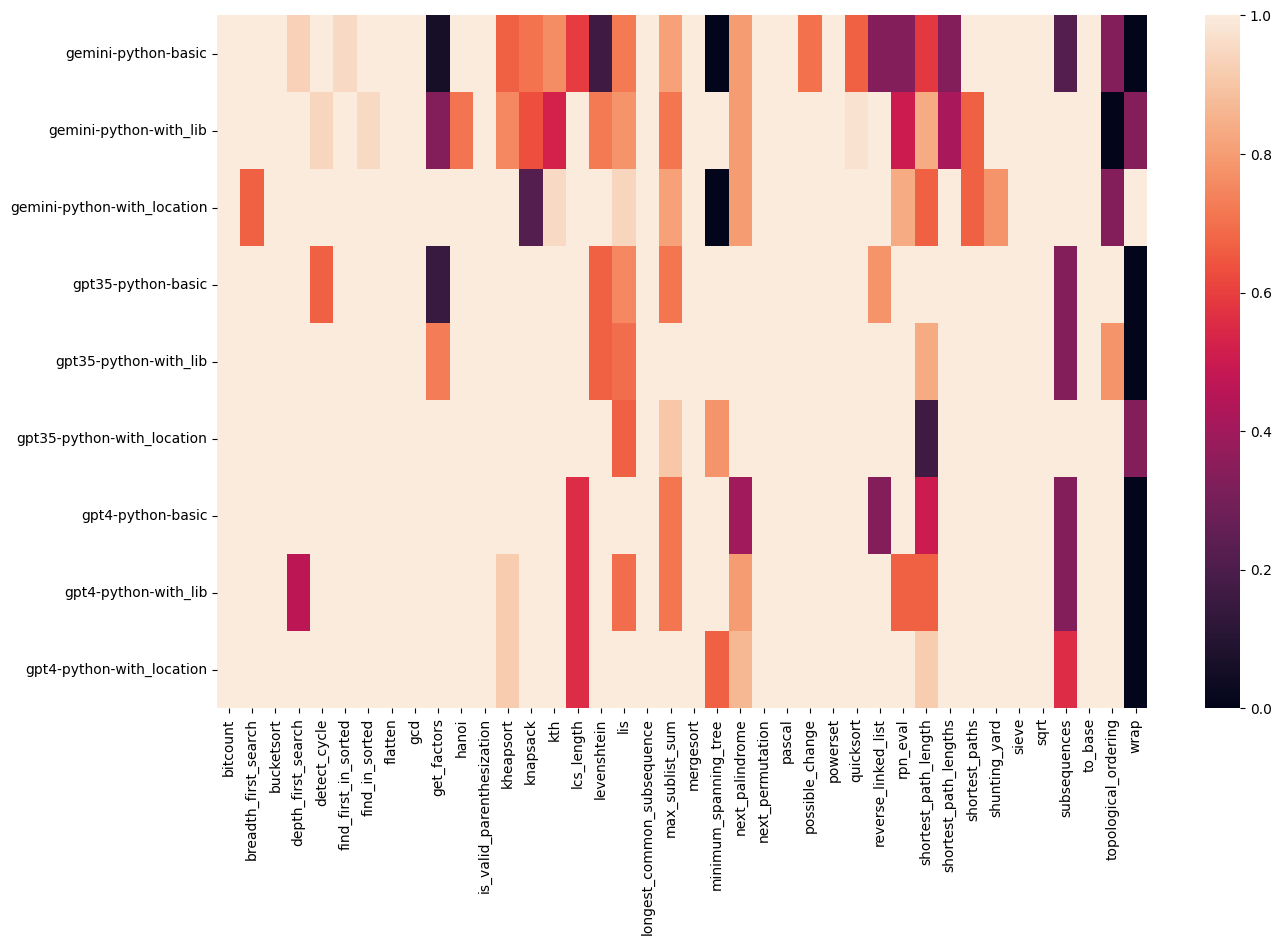

In [203]:

fig, ax = plt.subplots(figsize=(15, 9))

sns.heatmap(exp_plausible_df.transpose(), xticklabels=True, yticklabels=True,)


## Overview of all testing

<Axes: >

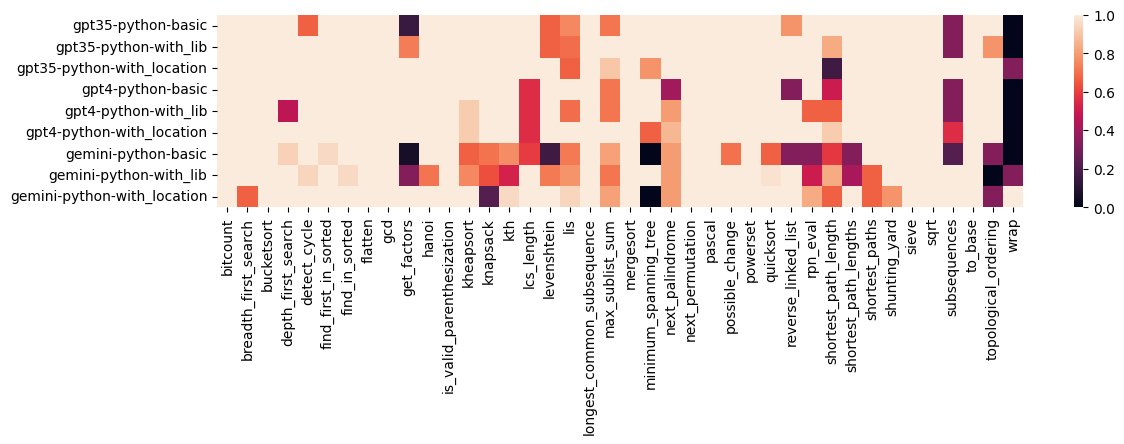

In [204]:

filtered_exp_names = [
    "gpt35-python-basic",
    "gpt35-python-with_lib",
    "gpt35-python-with_location",
    "gpt4-python-basic",
    "gpt4-python-with_lib",
    "gpt4-python-with_location",
    "gemini-python-basic",
    "gemini-python-with_lib",
    "gemini-python-with_location",
    # "claude-python-basic",
]

fig, ax = plt.subplots(figsize=(13, 2.5))
sns.heatmap(exp_plausible_df[filtered_exp_names].transpose(), xticklabels=True, yticklabels=True,)


<Axes: >

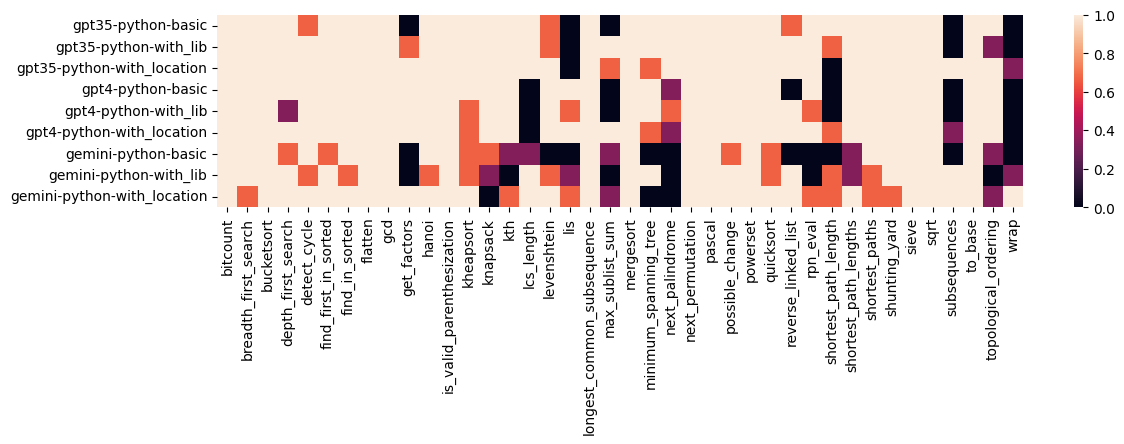

In [205]:
fig, ax = plt.subplots(figsize=(13, 2.5))
sns.heatmap(exp_correct_df[filtered_exp_names].transpose(), xticklabels=True, yticklabels=True,)


## Grouping heatmap

<Axes: >

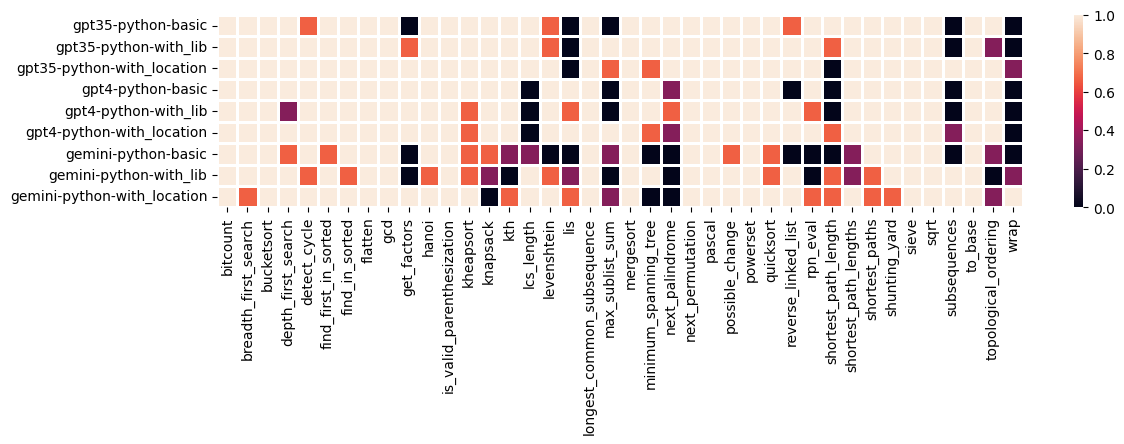

In [206]:
fig, ax = plt.subplots(figsize=(13, 2.5))
sns.heatmap(
    exp_correct_df[filtered_exp_names].transpose(),
    xticklabels=True,
    yticklabels=True,
    linewidths=1
)

## Bar chart of grouping

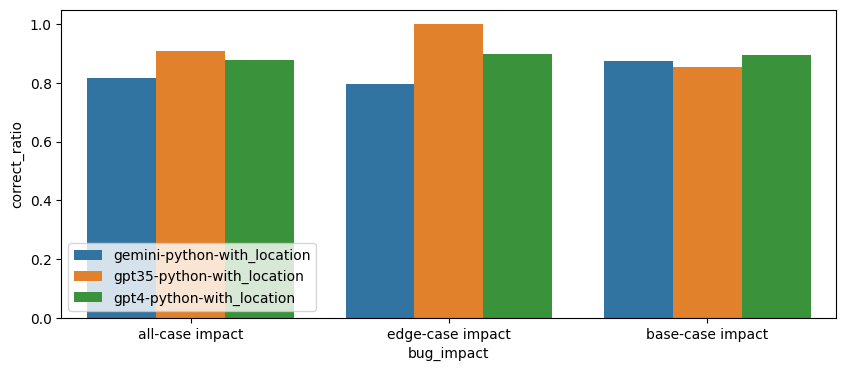

In [207]:
temp_selected_exp_names = [
    "gpt35-python-with_location",
    "gpt4-python-with_location",
    "gemini-python-with_location",
]

filtered_correct_ratio_df = correct_ratio_df[correct_ratio_df["exp_name"].isin(temp_selected_exp_names)]

fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(data=filtered_correct_ratio_df, x="bug_impact", y="correct_ratio", errorbar=None, hue="exp_name")
plt.legend(loc='lower left')


## 可用性和穩定性

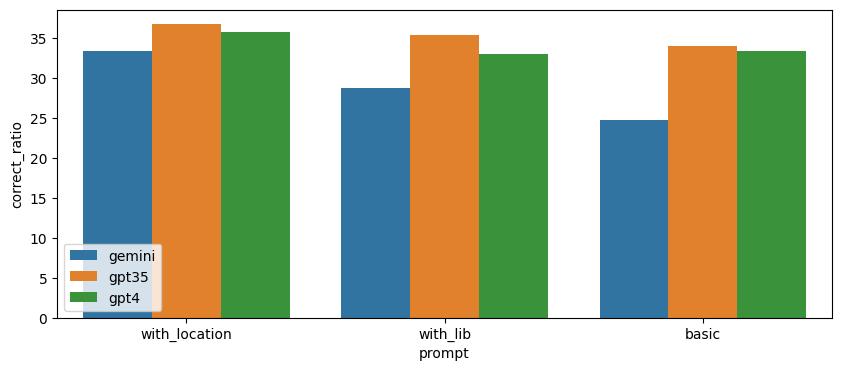

In [208]:
filtered_correct_ratio_df = correct_ratio_df[
    correct_ratio_df["exp_name"].isin(filtered_exp_names)
]
filtered_correct_ratio_df = filtered_correct_ratio_df[filtered_correct_ratio_df["correct_ratio"] > 0]

fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(
    data=filtered_correct_ratio_df,
    x="prompt",
    y="correct_ratio",
    errorbar=None,
    hue="model",
    estimator="sum"
)
plt.legend(loc="lower left")

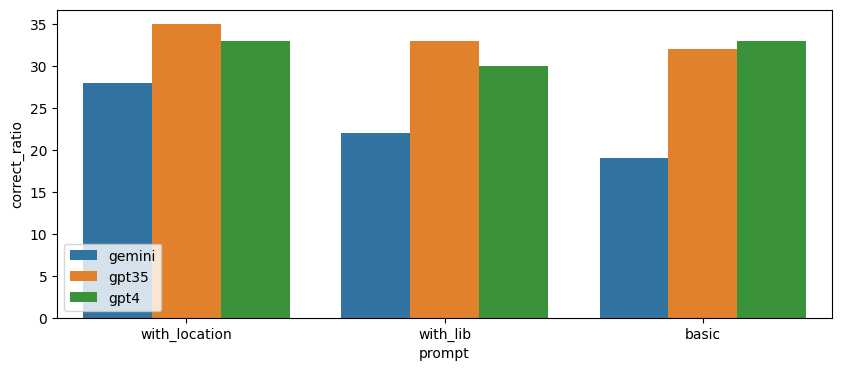

In [209]:
filtered_correct_ratio_df = correct_ratio_df[
    correct_ratio_df["exp_name"].isin(filtered_exp_names)
]
filtered_correct_ratio_df = filtered_correct_ratio_df[filtered_correct_ratio_df["correct_ratio"] == 1]

fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(
    data=filtered_correct_ratio_df,
    x="prompt",
    y="correct_ratio",
    errorbar=None,
    hue="model",
    estimator="sum"
)
plt.legend(loc="lower left")

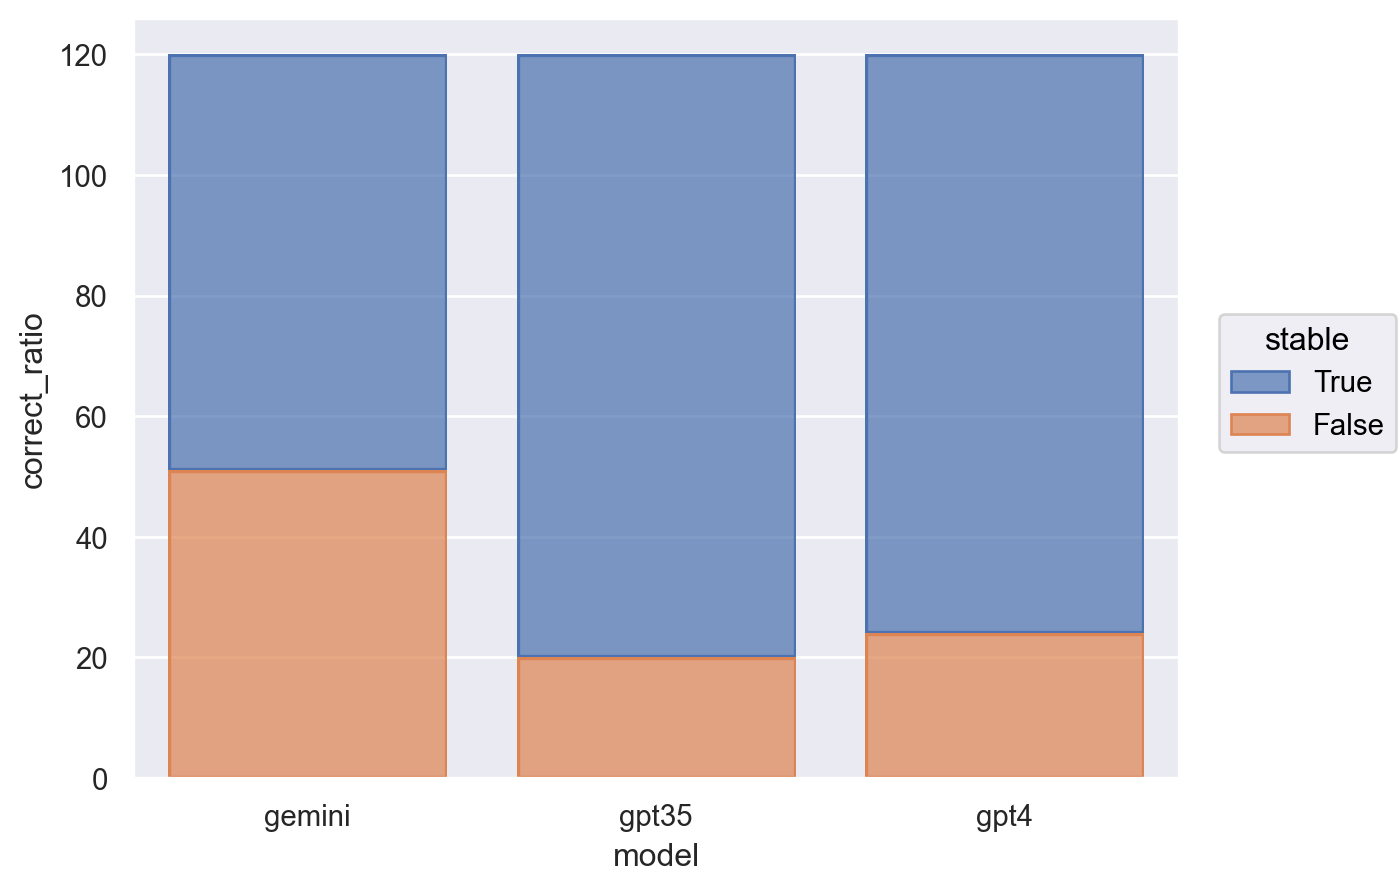

In [212]:
filtered_correct_ratio_df = correct_ratio_df[
    correct_ratio_df["exp_name"].isin(filtered_exp_names)
]

so.Plot(
    filtered_correct_ratio_df,
    x="model",
    y="correct_ratio",
    color="stable",
    ).add(
    so.Bar(), so.Count(), so.Stack()
)

# Temp md file


In [211]:
exp_name = "gpt4-python-with_location"
patch_dir = base_dir / exp_name / "patchs"

patch_files = sorted(patch_dir.glob("*.json"), key=lambda s: int(s.name.split(".")[0]))

with open("temp.md", "w") as f:
    f.write(f"# {exp_name}\n\n")

    for patch_file in patch_files:
        with open(patch_file) as jf:
            json_content = json.load(jf)

        patches = json_content["patches"]
        sample = json_content["prompt"]["sample"]

        prog_id = sample["prog_id"]
        prog_name = sample["prog_name"]
        bug_detail_desc = sample["bug_detail_desc"]

        text = (
            f"## {prog_id}.{prog_name}\n"
            "\n"
            f"Bug detail: {bug_detail_desc}\n"
            "\n"
            "### Patchs\n"
            "#### Patch 0\n"
            f"{patches[0]['raw_code']}\n"
            "#### Patch 1\n"
            f"{patches[1]['raw_code']}\n"
            "#### Patch 2\n"
            f"{patches[2]['raw_code']}\n"
        )

        f.write(text)